# Imports

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime

def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

def string_to_time(date):

    date = datetime.strptime(date, '%Y-%m-%d')
    date = datetime.timestamp(date)
    return date

def normalize(x, min, max):
    return (x - min)/(max - min)

def reverse_normalize(y, min, max):
    return y*(max - min) + min

def min_max_dic(dataset):
    dic = {}
    for col in dataset.columns:
        dic[col] = [dataset[col].min(), dataset[col].max()]
        dataset[col] = dataset[col].apply(lambda x: normalize(x, dic[col][0], dic[col][1]))
    return dic

In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()

        self.lstm = nn.GRU(input_size, hidden_dim, num_layers)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = output[:,-1,:]
        output = self.linear(output)
        return output

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import operator
from datetime import datetime



# Define CUDA

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load Dataset

In [ ]:
#stocks dataset for Altaba Inc
stock_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bid.csv')
display(stock_dataset)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-05,9101.712891,9172.269531,9101.712891,9101.712891,9101.712891,94080
1,2015-01-06,9031.157227,9383.936523,9031.157227,9313.380859,9313.380859,571418
2,2015-01-07,9313.380859,9595.604492,9242.825195,9595.604492,9595.604492,1177264
3,2015-01-08,9595.604492,9736.716797,9454.493164,9595.604492,9595.604492,1131356
4,2015-01-09,9595.604492,10230.608398,9595.604492,10230.608398,10230.608398,4664782
...,...,...,...,...,...,...,...
2296,2024-03-20,51600.000000,53100.000000,50500.000000,53000.000000,53000.000000,3132600
2297,2024-03-21,53200.000000,53400.000000,52800.000000,53000.000000,53000.000000,1884700
2298,2024-03-22,53300.000000,56700.000000,53300.000000,54200.000000,54200.000000,4361200
2299,2024-03-25,54200.000000,55500.000000,52700.000000,53000.000000,53000.000000,1289800


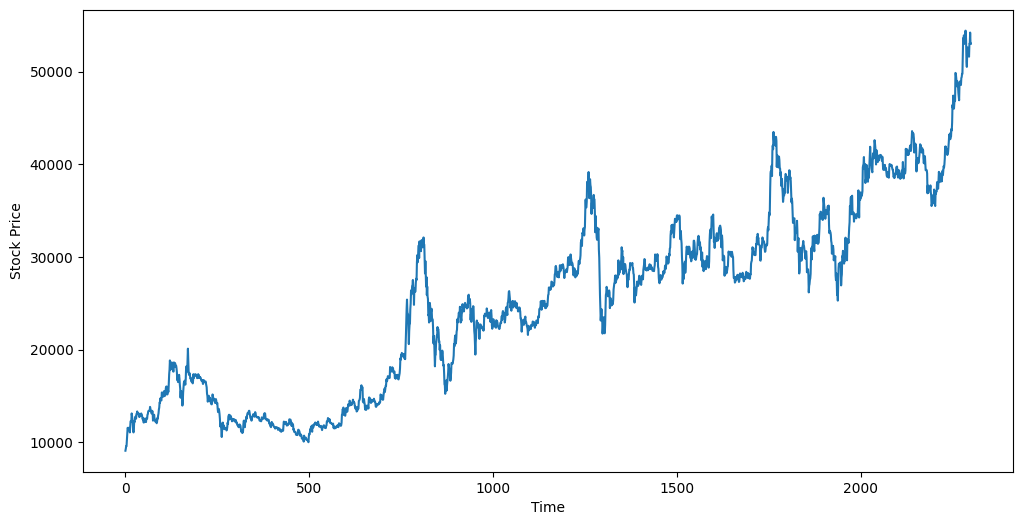

In [ ]:
#close value is stock price at the end of that day
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(stock_dataset))), stock_dataset['Close'])
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

# Proprocess Dataset

In [ ]:
#normalize dataset and keep track of close value
stock_dataset['Date'] = stock_dataset['Date'].apply(lambda x: string_to_time(x))
min_max_dictionary = min_max_dic(stock_dataset)
display(stock_dataset)

stock_value = stock_dataset[['Close']]

,Date,Open,High,Low,Close,Adj Close,Volume
0,0.000000,0.001555,0.000000,0.001587,0.000000,0.000000,0.000000
1,0.000297,0.000000,0.004454,0.000000,0.004673,0.004673,0.021404
2,0.000594,0.006221,0.008907,0.004760,0.010903,0.010903,0.048571
3,0.000891,0.012441,0.011876,0.009520,0.010903,0.010903,0.046513
4,0.001188,0.012441,0.022268,0.012693,0.024921,0.024921,0.204955
...,...,...,...,...,...,...,...
2296,0.998219,0.938284,0.924255,0.932537,0.969094,0.969094,0.136251
2297,0.998515,0.973550,0.930567,0.984259,0.969094,0.969094,0.080293
2298,0.998812,0.975754,1.000000,0.995502,0.995585,0.995585,0.191342
2299,0.999703,0.995592,0.974752,0.982010,0.969094,0.969094,0.053617


In [ ]:
#split data into training and testing components
x_train, y_train, x_test, y_test = split_data(stock_value, 20)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

# Initialize Hyperparameters

In [ ]:
input_size = 1
hidden_dim = 64
num_layers = 3
output_dim = 1
epochs = 100

# Define Model (GRU)

In [ ]:
model = LSTM(input_size, hidden_dim, num_layers, output_dim).to(device)
loss_func = nn.MSELoss(reduction='mean').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train Model

In [ ]:
train_loss = []
min_loss = np.Inf

for epoch in range(epochs):
    #zero out gradients
    optimizer.zero_grad()

    pred = model(x_train.to(device))
    loss = loss_func(pred, y_train.to(device))
    train_loss.append(loss.item())
    print('Epoch {},    Loss: {:.10f}\n'.format(epoch, loss.item()))

    #keep track of lowest loss and save as best model
    if loss.item() < min_loss:
        print('     New Minimum Loss: {:.10f} ----> {:.10f}\n'.format(min_loss, loss.item()))
        min_loss = loss.item()
        torch.save(model.state_dict(), 'best_model.pt')

    #back propogate
    loss.backward()
    optimizer.step()

Epoch 0,    Loss: 0.0003008808

     New Minimum Loss: inf ----> 0.0003008808

Epoch 1,    Loss: 0.0003002145

     New Minimum Loss: 0.0003008808 ----> 0.0003002145

Epoch 2,    Loss: 0.0002995521

     New Minimum Loss: 0.0003002145 ----> 0.0002995521

Epoch 3,    Loss: 0.0002988937

     New Minimum Loss: 0.0002995521 ----> 0.0002988937

Epoch 4,    Loss: 0.0002982392

     New Minimum Loss: 0.0002988937 ----> 0.0002982392

Epoch 5,    Loss: 0.0002975886

     New Minimum Loss: 0.0002982392 ----> 0.0002975886

Epoch 6,    Loss: 0.0002969418

     New Minimum Loss: 0.0002975886 ----> 0.0002969418

Epoch 7,    Loss: 0.0002962989

     New Minimum Loss: 0.0002969418 ----> 0.0002962989

Epoch 8,    Loss: 0.0002956596

     New Minimum Loss: 0.0002962989 ----> 0.0002956596

Epoch 9,    Loss: 0.0002950241

     New Minimum Loss: 0.0002956596 ----> 0.0002950241

Epoch 10,    Loss: 0.0002943923

     New Minimum Loss: 0.0002950241 ----> 0.0002943923

Epoch 11,    Loss: 0.0002937641

     Ne

# Evaluating Model

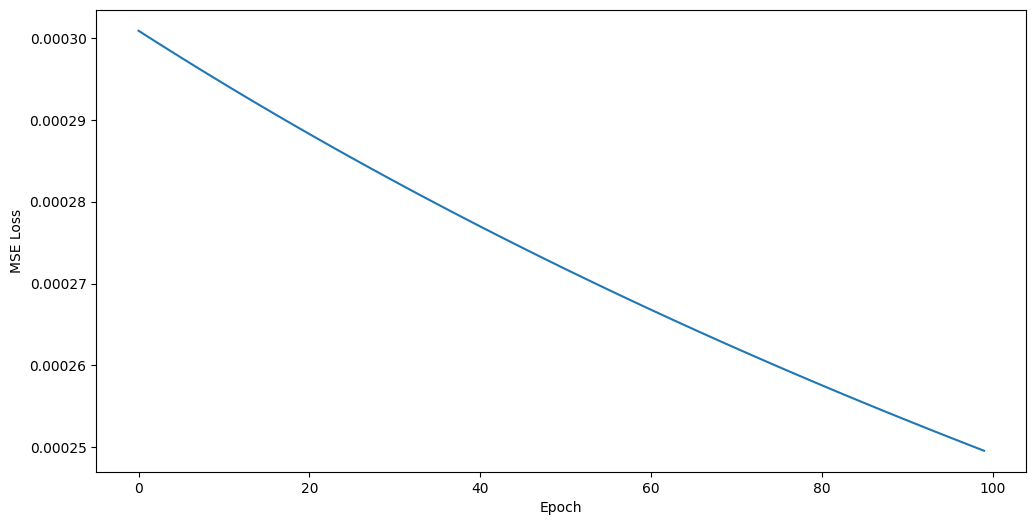

In [ ]:
#visualize loss throughout training
plt.figure(figsize=(12, 6))
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.plot(list(range(epochs)), train_loss)

# Load the Best Model

In [ ]:
best_model = LSTM(input_size, hidden_dim, num_layers, output_dim).to(device)
best_model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [ ]:
#get predictions
lstm_predictions = model(x_test.to(device))
test_loss = loss_func(lstm_predictions, y_test.to(device))
lstm_predictions = lstm_predictions.squeeze().tolist()


# Reverse Normalize

In [ ]:
min = min_max_dictionary['Close'][0]
max = min_max_dictionary['Close'][1]

#reverse normalize predictions and dataset values
lstm_predictions = [reverse_normalize(x, min, max) for x in np.array(lstm_predictions)]

stock_value = [reverse_normalize(x, min, max) for x in np.array(stock_value)]

# Visualizing and Testing Model

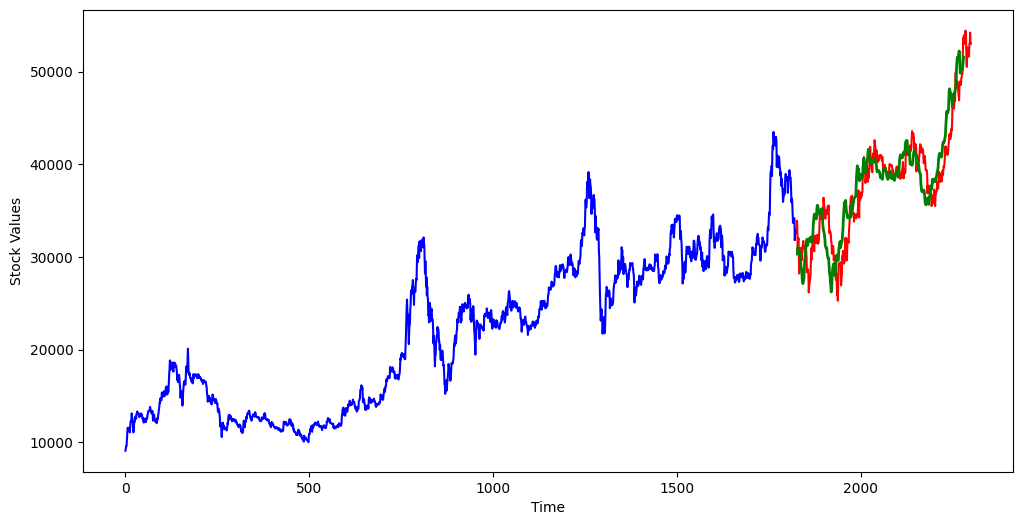

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(x_train.size(0))], stock_value[:x_train.size(0)], color='b', label='trained values')

#plot test range and predictions by the GRU
time_values_actual = list(range(x_train.size(0), len(stock_value)))
time_values_pred = list(range(x_train.size(0), x_train.size(0) + y_test.size(0)))
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.plot(time_values_actual, stock_value[-len(time_values_actual):], color='r', label='actual values')
plt.plot(time_values_pred[3:], lstm_predictions[3:], color='g', linewidth=2, label='predicted values')

plt.show()